In [1]:
!pip install pyspark


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.style.use('ggplot')
sns.set_style("whitegrid")

from scipy import stats

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, VectorIndexer, StringIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.regression import GBTRegressor

In [5]:
conf = SparkConf().set("spark.ui.showConsoleProgress", "false")
sc = SparkContext(appName="Pyspark, SQL and Machine Learning for salary prediction", conf=conf)
sc

24/03/20 07:57:35 WARN Utils: Your hostname, Prateeks-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.14 instead (on interface en0)
24/03/20 07:57:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/20 07:57:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/20 07:57:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/03/20 07:57:36 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


<SparkContext master=local[*] appName=Pyspark, SQL and Machine Learning for salary prediction>

In [6]:
spark = SparkSession(sc)
spark.sparkContext.setLogLevel("ERROR")

In [7]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

In [8]:
path = '/Users/prateek_11/Desktop/apache2/archive/'
df_path = path + 'train_dataset.csv'
df1_path = path + 'train_salaries.csv'

# Dataset Loading and first analysis

In [9]:
df1 = spark.read.csv(df_path, header=True).cache()

In [10]:
df2 = spark.read.csv(df1_path, header=True).cache()

In [11]:
df1.show(5)

+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|           jobId|companyId|       jobType|     degree|    major|industry|yearsExperience|milesFromMetropolis|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|  HEALTH|             10|                 83|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|     WEB|              3|                 73|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|  PHYSICS|  HEALTH|             10|                 38|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL|CHEMISTRY|    AUTO|              8|                 17|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|  PHYSICS| FINANCE|              8|                 16|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
o

In [12]:
df2.show(5)

+----------------+------+
|           jobId|salary|
+----------------+------+
|JOB1362684407687|   130|
|JOB1362684407688|   101|
|JOB1362684407689|   137|
|JOB1362684407690|   142|
|JOB1362684407691|   163|
+----------------+------+
only showing top 5 rows



In [13]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: string (nullable = true)
 |-- milesFromMetropolis: string (nullable = true)



In [14]:
df2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: string (nullable = true)



In [15]:
df1 = df1.withColumn("yearsExperience",df1.yearsExperience.cast('int'))
df1 = df1.withColumn("milesFromMetropolis",df1.milesFromMetropolis.cast('int'))

In [16]:
df2 = df2.withColumn("salary", df2.salary.cast('int'))

In [17]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: integer (nullable = true)
 |-- milesFromMetropolis: integer (nullable = true)



In [18]:
df2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: integer (nullable = true)



In [19]:
df2 = df2.withColumnRenamed('jobId', 'job_id')

Joining the spark dataframe 1 and 2 using job_id as a key

In [20]:
df = df1.join(df2, df1.jobId==df2.job_id)

In [21]:
df = df.drop('job_id')

In [22]:
df.show(5)

+----------------+---------+--------------+-----------+--------+--------+---------------+-------------------+------+
|           jobId|companyId|       jobType|     degree|   major|industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+--------------+-----------+--------+--------+---------------+-------------------+------+
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|    NONE|     WEB|              3|                 73|   101|
|JOB1362684407693|   COMP15|           CFO|       NONE|    NONE|  HEALTH|             23|                 24|   178|
|JOB1362684407724|    COMP8|VICE_PRESIDENT|   DOCTORAL|BUSINESS|  HEALTH|             24|                 35|   183|
|JOB1362684407739|    COMP5|        JUNIOR|    MASTERS| BIOLOGY| FINANCE|             11|                 72|    88|
|JOB1362684407741|   COMP44|       JANITOR|HIGH_SCHOOL|    NONE|    AUTO|              9|                  4|    91|
+----------------+---------+--------------+-----------+--------+

# Duplicated data check

In [23]:
df_dup=df.groupBy("yearsExperience", "milesFromMetropolis","companyId","jobType", "degree", "major", "industry", "jobId").count().filter("count > 1")
df_dup.drop('count').show()

+---------------+-------------------+---------+-------+------+-----+--------+-----+
|yearsExperience|milesFromMetropolis|companyId|jobType|degree|major|industry|jobId|
+---------------+-------------------+---------+-------+------+-----+--------+-----+
+---------------+-------------------+---------+-------+------+-----+--------+-----+



No Duplicate Data


# Missing Values check

In [24]:
df.show(10)

+----------------+---------+--------------+-----------+----------+---------+---------------+-------------------+------+
|           jobId|companyId|       jobType|     degree|     major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+--------------+-----------+----------+---------+---------------+-------------------+------+
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|      NONE|      WEB|              3|                 73|   101|
|JOB1362684407693|   COMP15|           CFO|       NONE|      NONE|   HEALTH|             23|                 24|   178|
|JOB1362684407724|    COMP8|VICE_PRESIDENT|   DOCTORAL|  BUSINESS|   HEALTH|             24|                 35|   183|
|JOB1362684407739|    COMP5|        JUNIOR|    MASTERS|   BIOLOGY|  FINANCE|             11|                 72|    88|
|JOB1362684407741|   COMP44|       JANITOR|HIGH_SCHOOL|      NONE|     AUTO|              9|                  4|    91|
|JOB1362684407746|   COMP11|VICE_PRESIDE

No missing values

In [25]:
print('Number of missing values for jobType: {}'.format(df.filter(df.jobType=='NONE').count()))
print('Number of missing values for degree: {}'.format(df.filter(df.degree=='NONE').count()))
print('Number of missing values for major: {}'.format(df.filter(df.major=='NONE').count()))
print('Number of missing values for industry: {}'.format(df.filter(df.industry=='NONE').count()))

Number of missing values for jobType: 0
Number of missing values for degree: 236854
Number of missing values for major: 532355
Number of missing values for industry: 0


The NONE value indicates that the worker dont have any degree

# Dataset Analayis

In [26]:
df.describe(['yearsExperience', 'milesFromMetropolis','salary']).show()

+-------+-----------------+-------------------+-----------------+
|summary|  yearsExperience|milesFromMetropolis|           salary|
+-------+-----------------+-------------------+-----------------+
|  count|          1000000|            1000000|          1000000|
|   mean|        11.992386|           49.52926|       116.061818|
| stddev|7.212390868885733|  28.87773262871997|38.71793638113317|
|    min|                0|                  0|                0|
|    max|               24|                 99|              301|
+-------+-----------------+-------------------+-----------------+



# Q1 Which is the highest paid job?

In [27]:
df.createOrReplaceTempView("data")

In [28]:
spark.sql('''
    SELECT salary, jobtype, industry
    FROM data
    WHERE salary == (SELECT MAX(salary) FROM data)''').show()

+------+-------+--------+
|salary|jobtype|industry|
+------+-------+--------+
|   301|    CFO|     OIL|
|   301|    CTO|     OIL|
+------+-------+--------+



The highest paid jobs are CFO (Chief financial officer) and CTO (Chief technology officer ) in the OIL industry, with a salary of 301k.

# Q2 Which are the TOP 20 jobs in terms of highest salary?

In [29]:
df_q2 = spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary DESC) Rank
          FROM data
          ORDER BY salary DESC
          LIMIT 20''')
df_q2.show(20)

+------+-------+--------+----+
|salary|jobtype|industry|Rank|
+------+-------+--------+----+
|   301|    CFO|     OIL|   1|
|   301|    CTO|     OIL|   1|
|   298|    CEO|     OIL|   3|
|   294|    CEO| FINANCE|   1|
|   294|    CEO|     OIL|   4|
|   293|    CEO| FINANCE|   2|
|   293|    CEO|     OIL|   5|
|   292|    CTO| FINANCE|   3|
|   292|    CEO| FINANCE|   3|
|   290|    CEO|     WEB|   1|
|   289|    CEO| FINANCE|   5|
|   289|    CFO|     OIL|   6|
|   289|    CTO|     WEB|   2|
|   288|    CFO| FINANCE|   6|
|   288|    CFO| FINANCE|   6|
|   287|    CEO|     OIL|   7|
|   287|    CEO| FINANCE|   8|
|   286|    CEO|     OIL|   8|
|   286|    CTO| FINANCE|   9|
|   286|    CEO| FINANCE|   9|
+------+-------+--------+----+



We can find the previous result (obtained with a subquery) of the highest paid jobs, in particular we can see that 8 of the TOP20 paid jobs are in the OIL industry(5 of them in the TOP10), 10  are from FINANCE and 2 are from WEB. We also added a Rank column to improve the readability of the result.

# Q3 Which is the least paid job?

In [30]:
spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary ASC) Rank
          FROM data
          ORDER BY salary ASC''').show()

+------+--------------+---------+----+
|salary|       jobtype| industry|Rank|
+------+--------------+---------+----+
|     0|       MANAGER|  FINANCE|   1|
|     0|        JUNIOR|     AUTO|   1|
|     0|VICE_PRESIDENT|      WEB|   1|
|     0|           CTO|     AUTO|   1|
|     0|        JUNIOR|      OIL|   1|
|    17|       JANITOR|EDUCATION|   1|
|    18|       JANITOR|EDUCATION|   2|
|    18|       JANITOR|EDUCATION|   2|
|    18|       JANITOR|EDUCATION|   2|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    20|       JANITOR|EDUCATION|  15|
+------+--------------+---------+----+
only showing top 20 rows



We can clearly see that the jobs with 0\\$ salary are probably missing values, since they are related for example to OIL and WEB industries, which are very well paid (as seen before). Moreover, there is also a 'vice president' job, which is impossible to have 0$ salary. We will drop these rows. <br>


In [31]:
df = df.where("salary != 0")

Then, we also need to reload the table since we updated the dataframe df.

In [32]:
df.createOrReplaceTempView("data")

In [33]:
df_q3 = spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary ASC) Rank
          FROM data
          ORDER BY salary ASC''')
df_q3.show()

+------+-------+---------+----+
|salary|jobtype| industry|Rank|
+------+-------+---------+----+
|    17|JANITOR|EDUCATION|   1|
|    18|JANITOR|EDUCATION|   2|
|    18|JANITOR|EDUCATION|   2|
|    18|JANITOR|EDUCATION|   2|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
+------+-------+---------+----+
only showing top 20 rows



We can see that now the lowest paid job is 'janitor', with a minimum salary of 17k.

# Q4 Which are the TOP 3 industries in terms of highest salary?

In [34]:
df_q4 = spark.sql('''
          SELECT industry, AVG(salary) as average_salary
          FROM data
          GROUP BY industry
          ORDER BY average_salary DESC''')
df_q4.show(10)

+---------+------------------+
| industry|    average_salary|
+---------+------------------+
|      OIL|130.95386285634237|
|  FINANCE|  130.747658645164|
|      WEB| 121.6453615446388|
|   HEALTH| 115.7355399110364|
|     AUTO|109.43522152496485|
|  SERVICE|104.44682029458984|
|EDUCATION| 99.44838571898697|
+---------+------------------+



Converting spark data frame to pandas to plot it using matplotlib and sns

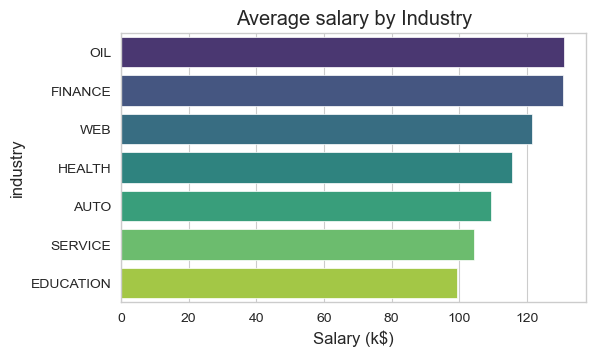

In [35]:
df_p = df_q4.toPandas()
plt.figure(figsize=(6,3.5))
sns.barplot(y='industry', x = 'average_salary', data=df_p, palette='viridis')
plt.title('Average salary by Industry')
plt.xlabel('Salary (k$)')
plt.show()

We can see first two industries are OIL and FINANCE, with have a very similar average salary of 130k. The third industry in terms of highest salary is WEB. We could expect this result by looking at the Q1 query result.

# Q5 Do workers with more years of experience get paid more?

In [36]:
df_q5 = spark.sql('''
    SELECT salary, jobtype, industry, yearsExperience
    FROM data
    ORDER BY salary DESC
    ''') 
df_q5.show()

+------+-------+--------+---------------+
|salary|jobtype|industry|yearsExperience|
+------+-------+--------+---------------+
|   301|    CFO|     OIL|             23|
|   301|    CTO|     OIL|             24|
|   298|    CEO|     OIL|             22|
|   294|    CEO|     OIL|             19|
|   294|    CEO| FINANCE|             24|
|   293|    CEO| FINANCE|             16|
|   293|    CEO|     OIL|             24|
|   292|    CEO| FINANCE|             22|
|   292|    CTO| FINANCE|             24|
|   290|    CEO|     WEB|             20|
|   289|    CEO| FINANCE|             23|
|   289|    CTO|     WEB|             24|
|   289|    CFO|     OIL|             23|
|   288|    CFO| FINANCE|             21|
|   288|    CFO| FINANCE|             24|
|   287|    CEO| FINANCE|             19|
|   287|    CEO|     OIL|             22|
|   286|    CEO| FINANCE|             24|
|   286|    CEO|     OIL|             16|
|   286|    CTO| FINANCE|             24|
+------+-------+--------+---------

In order to improve the readability of the results, we will plot salary VS jobtype. Before doing so, we should check the different jobtypes in the dataframe:

In [37]:
df_q5.groupBy('jobtype').count().show()

+--------------+------+
|       jobtype| count|
+--------------+------+
|           CTO|125045|
|        JUNIOR|124592|
|       JANITOR|124971|
|           CFO|124369|
|           CEO|124778|
|       MANAGER|125120|
|VICE_PRESIDENT|125234|
|        SENIOR|125886|
+--------------+------+



In [38]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR','JANITOR']

Next we need to convert the extracted dataframe by SQL query Q5 into a pandas dataframe:

In [39]:
df_p = df_q5.toPandas()

Finally we can create the plots with a for loop, including a linear regression to improve the readability of the plots.

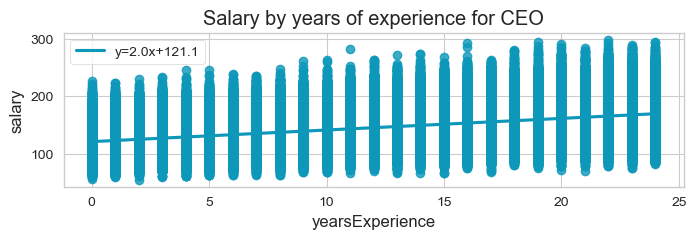

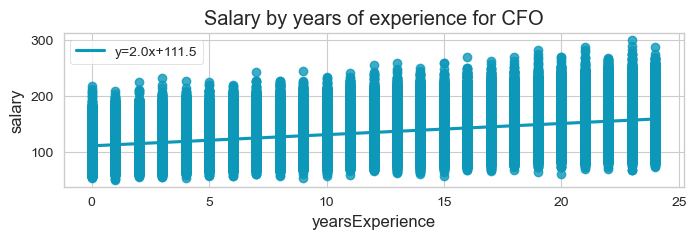

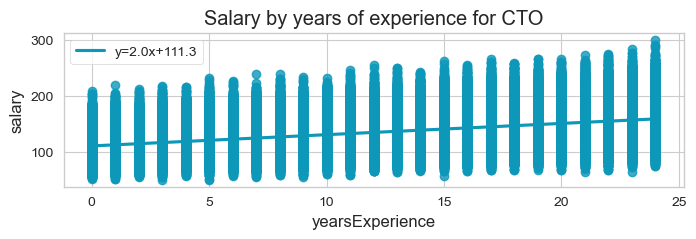

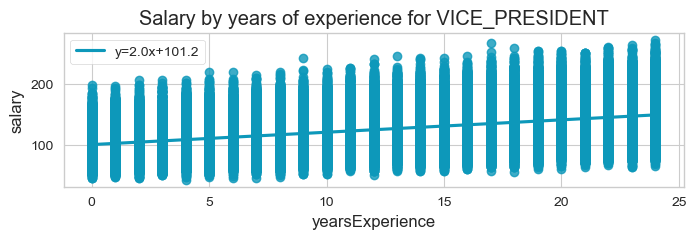

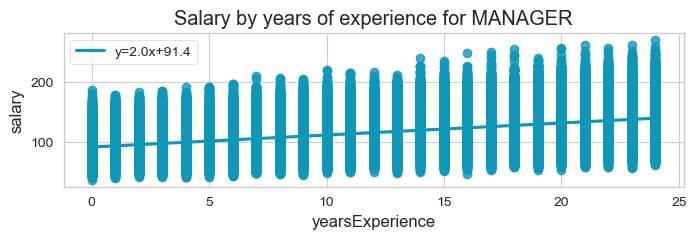

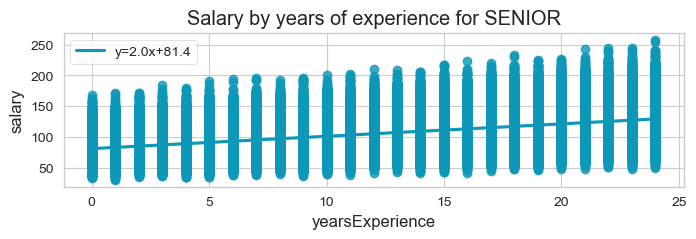

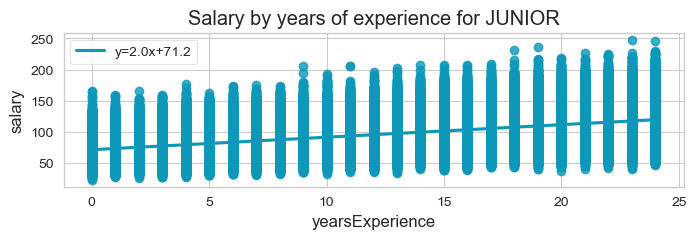

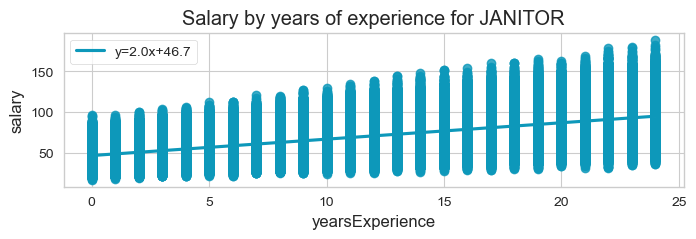

In [40]:
slope_list = []  #to save the slopes of the regression lines
intercept_list = [] #to save the intercepts of the regression lines

for job in job_list:
    df_x = df_p.loc[df_p['jobtype']==job]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_x['yearsExperience'],df_x['salary'])
    slope_list.append(slope)
    intercept_list.append(intercept)
    plt.figure(figsize=(8,2))
    sns.regplot(x='yearsExperience', y = 'salary', data=df_x, color='#0d98ba', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.legend()
    plt.title('Salary by years of experience for ' + job)
    plt.show()

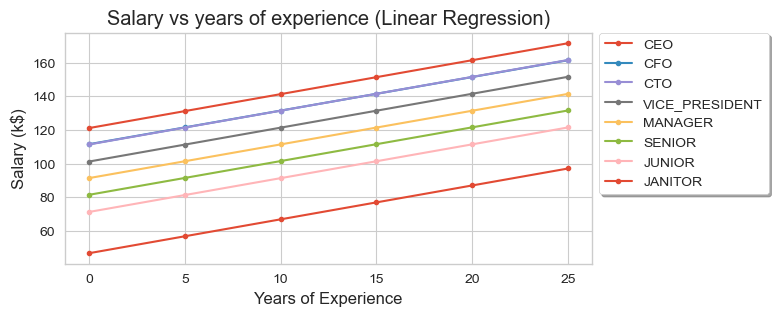

In [41]:
X = np.array([0, 5, 10, 15, 20, 25])
plt.figure(figsize=(6.8,3))
for i in range(8):
    plt.plot(X, slope_list[i]*X+intercept_list[i],label=job_list[i], marker='.')
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fancybox=True, shadow=True)
plt.ylabel('Salary (k$)')
plt.xlabel('Years of Experience')
plt.title('Salary vs years of experience (Linear Regression)')
plt.show()

# Q6 Do workers with higher degrees have better paid jobs?

In [42]:
df_q6 = spark.sql('''
                  SELECT degree, salary, jobtype
                  FROM data
                  ORDER BY salary
                  ''')
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       NONE|    17|JANITOR|
|       NONE|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       NONE|    19|JANITOR|
+-----------+------+-------+
only showing top 5 rows



We can see some NONE values in the degree column: we will drop the rows with no degree.

In [43]:
df_q6 = df_q6.replace('NONE',None)

In [44]:
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       NULL|    17|JANITOR|
|       NULL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       NULL|    19|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [45]:
df_q6 = df_q6.na.drop()

In [46]:
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    20|JANITOR|
+-----------+------+-------+
only showing top 5 rows



Then, as seen for Q5, we will extract a list of different degrees:

In [47]:
df_q6.groupBy('degree').count().show()

+-----------+------+
|     degree| count|
+-----------+------+
|  BACHELORS|175495|
|    MASTERS|175310|
|HIGH_SCHOOL|236975|
|   DOCTORAL|175362|
+-----------+------+



In [48]:
degrees_list = ['HIGH_SCHOOL','BACHELORS','DOCTORAL','MASTERS']

Finally we can convert the extracted dataframe by SQL query 'Q6' to a pandas dataframe in order to plot the desired result.

In [49]:
df_p = df_q6.toPandas()

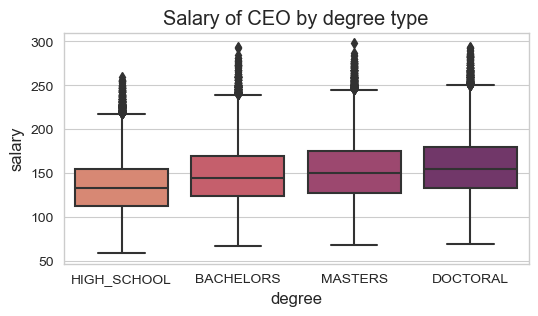

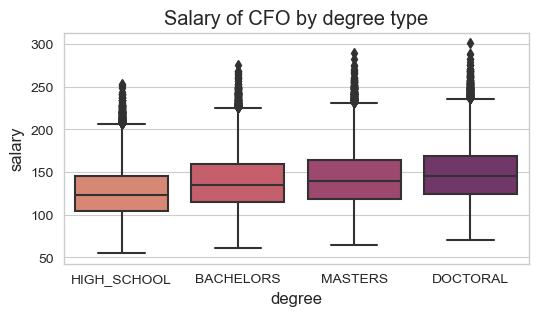

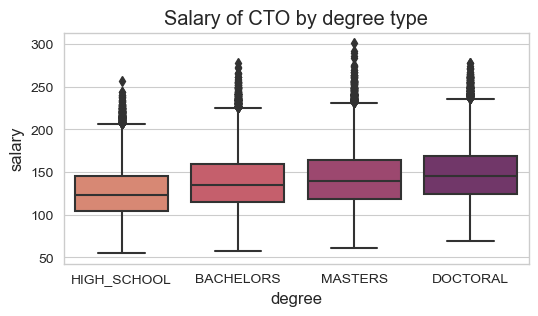

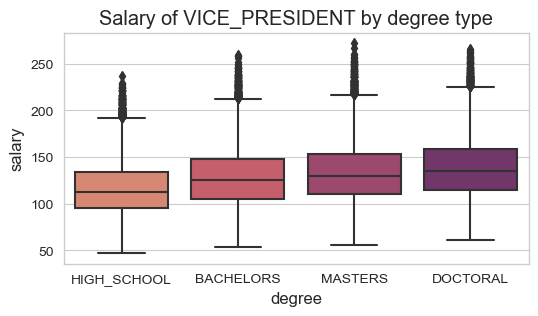

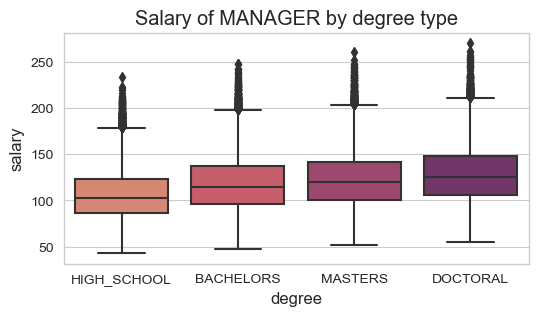

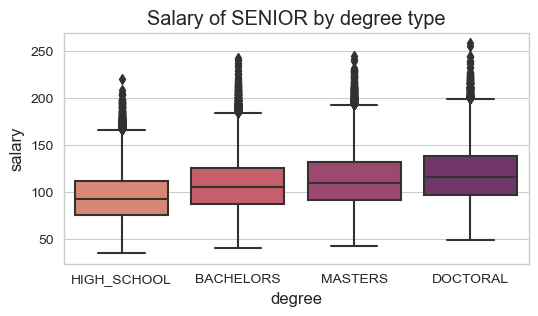

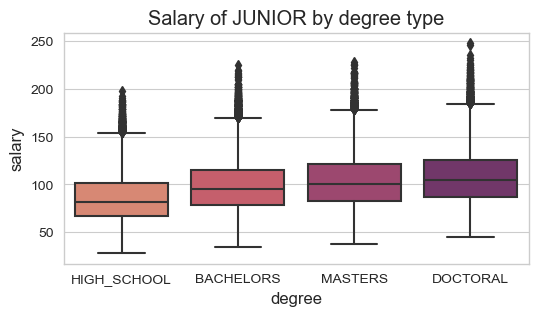

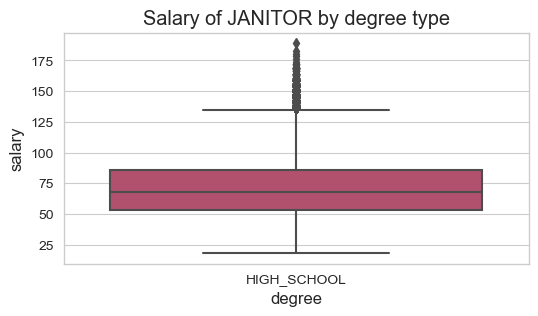

In [50]:
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  plt.figure(figsize=(6,3))
  sns.boxplot(x='degree', y = 'salary', data=df_x, palette='flare')
  plt.title('Salary of ' + job + ' by degree type')
  plt.show()

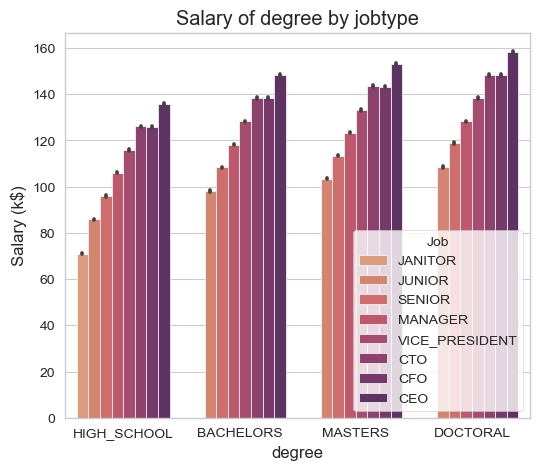

In [51]:
plt.figure(figsize=(6,5))
sns.barplot(x='degree', y = 'salary', data=df_p, hue='jobtype', palette='flare')
plt.legend(loc='lower right', title='Job')
plt.ylabel('Salary (k$)')
plt.title('Salary of degree by jobtype')
plt.show()

# Q7 Does the major affects the salary?

In [52]:
df_q7 = spark.sql('''
                  SELECT jobtype, degree, major, salary
                  FROM data
                  ORDER BY salary''')
df_q7.show(5)

+-------+-----------+-----+------+
|jobtype|     degree|major|salary|
+-------+-----------+-----+------+
|JANITOR|       NONE| NONE|    17|
|JANITOR|       NONE| NONE|    18|
|JANITOR|HIGH_SCHOOL| NONE|    18|
|JANITOR|HIGH_SCHOOL| NONE|    18|
|JANITOR|       NONE| NONE|    19|
+-------+-----------+-----+------+
only showing top 5 rows



We still have NONE values in degree and also in major (note: if the degree=High school, of course the major should be NONE!), we will drop these values!

In [53]:
df_q7 = df_q7.replace('NONE',None)
df_q7 = df_q7.na.drop()

In [54]:
df_q7.groupBy('major').count().show()

+-----------+-----+
|      major|count|
+-----------+-----+
|    BIOLOGY|58379|
|ENGINEERING|58594|
|    PHYSICS|58410|
|  CHEMISTRY|58875|
|   BUSINESS|58518|
|    COMPSCI|58382|
|       MATH|57800|
| LITERATURE|58684|
+-----------+-----+



In [55]:
df_q7.groupBy('jobtype').count().show()

+--------------+-----+
|       jobtype|count|
+--------------+-----+
|           CTO|66885|
|        JUNIOR|66465|
|           CFO|66427|
|           CEO|66754|
|       MANAGER|66832|
|VICE_PRESIDENT|66771|
|        SENIOR|67508|
+--------------+-----+



In this dataframe there is no JANITOR as a jobtype: it means that people with 'janitor' as a jobtype in the dataset all have 'High school' as degree, and so no major (as stated in the previous query Q6). We need to define a new list of jobs without janitor for the following plots!

In [56]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR']

In [57]:
df_p = df_q7.toPandas()

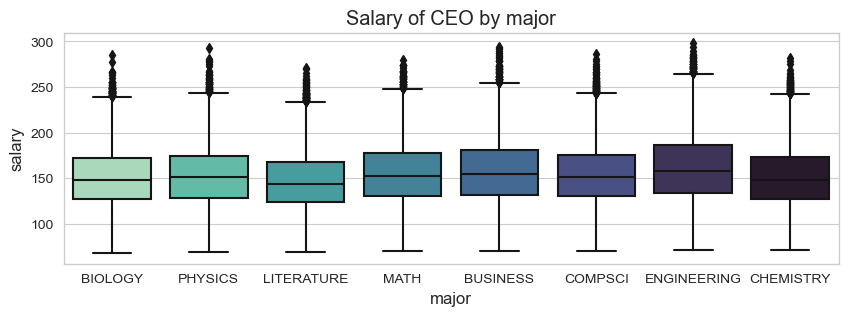

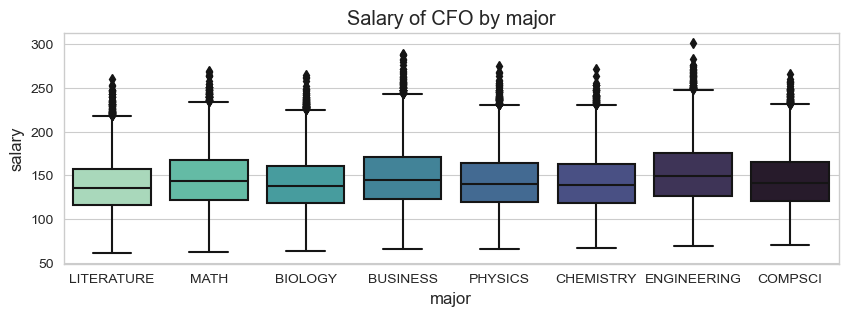

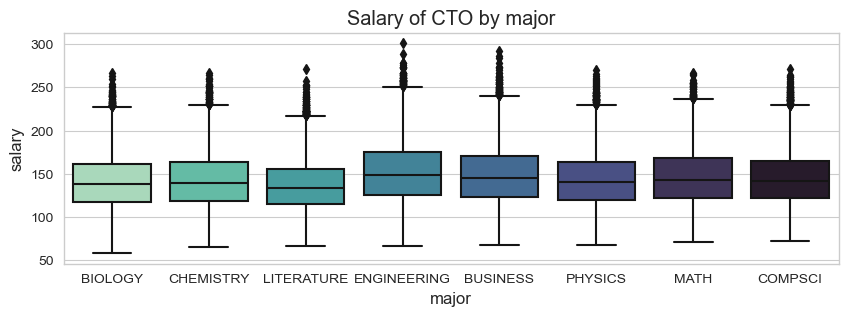

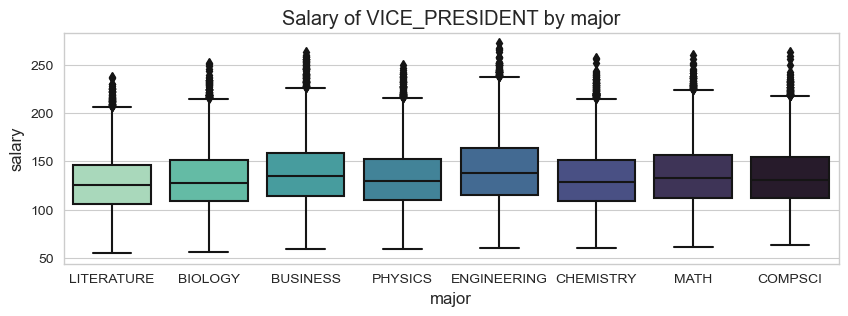

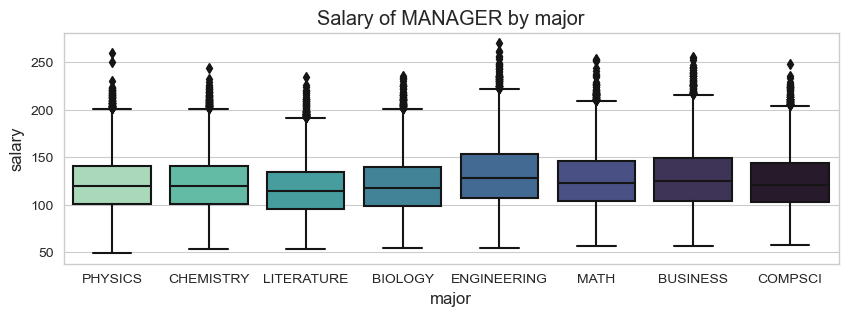

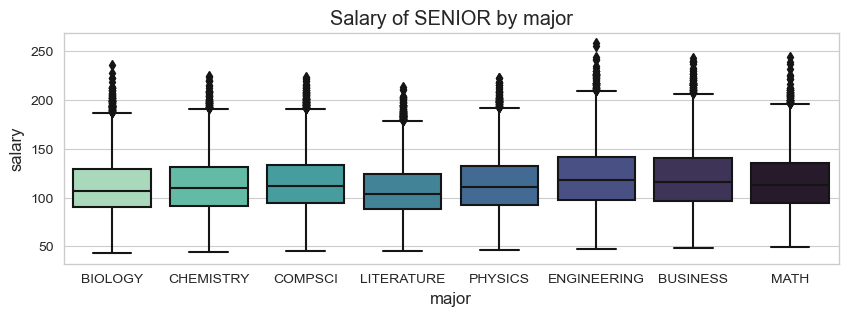

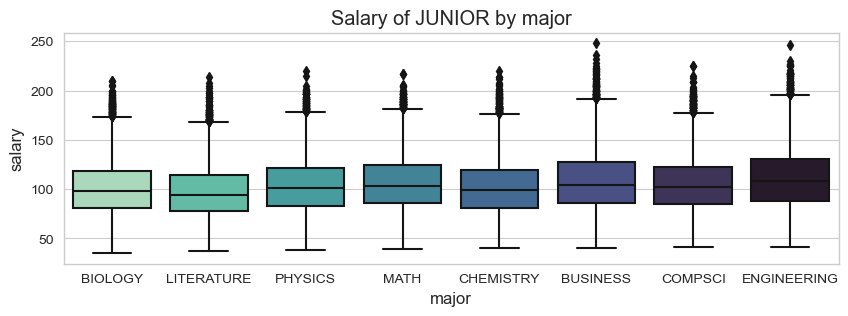

In [58]:
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  plt.figure(figsize=(10,3))
  sns.boxplot(x='major', y = 'salary', data=df_x, palette='mako_r')
  plt.title('Salary of ' + job + ' by major')
  plt.show()

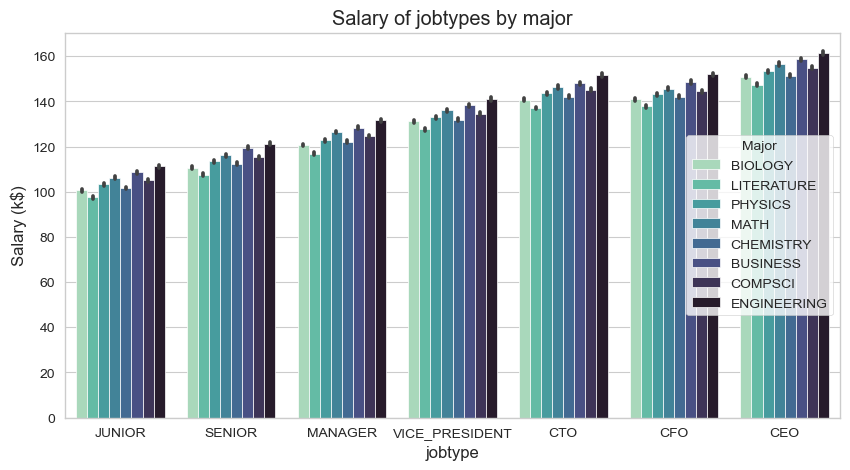

In [59]:
plt.figure(figsize=(10,5))
sns.barplot(x='jobtype', y = 'salary', data=df_p, hue='major', palette='mako_r')
plt.legend(loc='center right', title='Major')
plt.ylabel('Salary (k$)')
plt.title('Salary of jobtypes by major')
plt.show()

**We can see that engineering is the major the major of workers with higher salaries, business is the second and while literature is the major of workers with the lowest paid jobs.**

# ML Modeling

In this section we will prepreocess the data for ML training.

In [60]:
df.show(1)

+----------------+---------+-------+-----------+-----+--------+---------------+-------------------+------+
|           jobId|companyId|jobType|     degree|major|industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+-------+-----------+-----+--------+---------------+-------------------+------+
|JOB1362684407688|   COMP19|    CEO|HIGH_SCHOOL| NONE|     WEB|              3|                 73|   101|
+----------------+---------+-------+-----------+-----+--------+---------------+-------------------+------+
only showing top 1 row



First, we will create a copy of the dataframe called 'df_encoded', which will include the pre processed data.

In [61]:
df_encoded = df.alias('df_encoded')
id(df_encoded) == id(df)  # False

False

We remove the 'jobid' column since it just identifies a specific worker.

In [62]:
df_encoded = df_encoded.drop('jobId')

In [63]:
cols = df_encoded.columns

Moreover, it could be interesting to analyze the target variable 'salary':

In [64]:
salary_df = df_encoded.select('salary').toPandas()

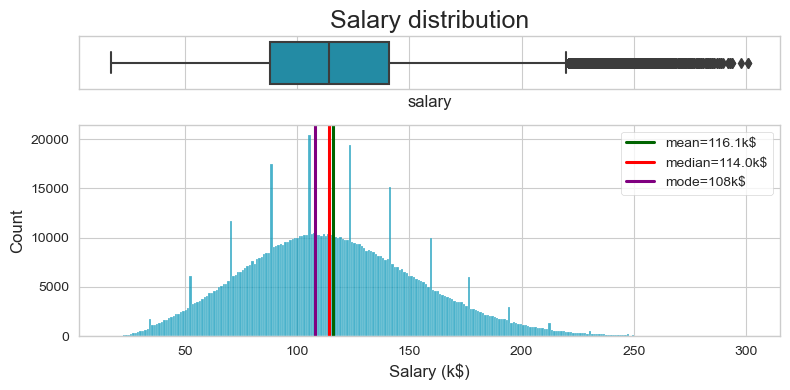

In [65]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,4),gridspec_kw={"height_ratios": (.2, .8)})
ax[0].set_title('Salary distribution',fontsize=18)
sns.boxplot(x='salary', data=salary_df, ax=ax[0], color='#0d98ba')
ax[0].set(yticks=[])
sns.histplot(x='salary', data=salary_df, ax=ax[1], color='#0d98ba')
plt.axvline(salary_df['salary'].mean(), color='darkgreen', linewidth=2.2, label='mean=' + str(np.round(salary_df['salary'].mean(),1)) + 'k$')
plt.axvline(salary_df['salary'].median(), color='red', linewidth=2.2, label='median='+ str(np.round(salary_df['salary'].median(),1)) + 'k$')
plt.axvline(salary_df['salary'].mode()[0], color='purple', linewidth=2.2, label='mode='+ str(salary_df['salary'].mode()[0]) + 'k$')
ax[1].set_xlabel('Salary (k$)')
plt.legend()
plt.tight_layout()
plt.show()

Salary feature has a right skewed long tail distribution, with some salaries which appears lots of times in the dataset (the "spikes" in this histograms).

## Label Encoding

Label encoding is a naive method to encode the categorical features. Label encoding should be used when there is a order among the categories.

In [66]:
categoricalColumns = ["companyId","jobType", "degree", "major", "industry"]
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    stages += [stringIndexer]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "Index" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In this dataset, the only categorical feature where there is a hieracrhy/order is degree, so we should encode this feature with label encoding.

In [67]:
stages = []
stringIndexer = StringIndexer(inputCol = "degree", outputCol = "degreeIndex")
stages += [stringIndexer]

EDIT: we improve the R2 by 0.8% by encoding 'degree' with label encoding instead of one hot encoding.

# One hot Encoding

In order to perform one hot encoding on the dataset, we need to first apply a string indexer, as seen in the label encoder, and then do the acutal one hot encoder. Finally, these steps will be added to a "stages" variable and passed a Pipeline object.

In [68]:
categoricalColumns = ["companyId","jobType", "major", "industry"]
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols + ["degreeIndex"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [69]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_encoded)
df_encoded = pipelineModel.transform(df_encoded)
selectedCols = ['features'] + cols
df_encoded = df_encoded.select(selectedCols)

In [70]:
df_encoded.show(1)

+--------------------+---------+-------+-----------+-----+--------+---------------+-------------------+------+
|            features|companyId|jobType|     degree|major|industry|yearsExperience|milesFromMetropolis|salary|
+--------------------+---------+-------+-----------+-----+--------+---------------+-------------------+------+
|(86,[13,67,69,77,...|   COMP19|    CEO|HIGH_SCHOOL| NONE|     WEB|              3|                 73|   101|
+--------------------+---------+-------+-----------+-----+--------+---------------+-------------------+------+
only showing top 1 row



We can see the presence of a "features" column, including all the different encoded features by one hot encoding and the numerical features. This column 'featurs' and the target column 'salary' will be passed to the ML algorithm during the training.

## Train test split 

In [71]:
train, test = df_encoded.randomSplit([0.995, 0.005], seed = 42)
print("There are %d training examples and %d test examples." % (train.count(), test.count()))

There are 995003 training examples and 4992 test examples.


# Gradient Boosting Trees

In [72]:
gbt =  GBTRegressor(featuresCol="features", labelCol="salary", maxBins=20, maxDepth=12)

In [73]:
gbt_model = gbt.fit(train)

In [74]:
predictions = gbt_model.transform(test)

# Prediction results

In [75]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse

19.673660278838394

In [76]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
r2

0.7370828386294068

In [77]:
rf_results = predictions.toPandas()

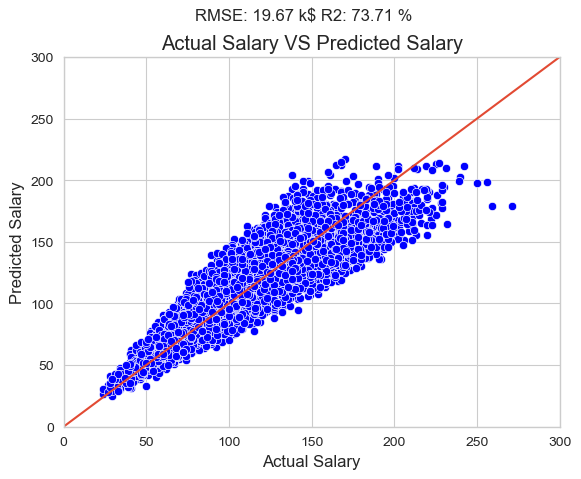

In [78]:
sns.scatterplot(x='salary', y='prediction', data=rf_results, color='blue')
plt.plot([0, 300], [0, 300])
plt.axis([0, 300, 0, 300])
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.suptitle("RMSE: {:.2f} k$ R2: {:.2f} %".format(rmse, r2*100))
plt.title('Actual Salary VS Predicted Salary')
plt.show()

In [79]:
print("RMSE: {:.2f} k$ \nR2: {:.2f} %".format(rmse, r2*100))

RMSE: 19.67 k$ 
R2: 73.71 %


In [80]:
spark.stop()